In [2]:
import pandas as pd
pd.set_option("display.max_columns", None)  # sets the max
import numpy as np
import scipy

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")


from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

rs = 1  # random state seed for reproducibility

from pathlib import Path
import pickle

# Fair PCA Experiments



## Functions



### Fair PCA

In [6]:
def fair_PCA(X, protected_features, n_components):

    Z = np.copy(protected_features)

    # Removing the mean from the protected features
    Z = Z-np.mean(Z)

    # Finding the orthonormal null-space spanned by Z^t X

    R = scipy.linalg.null_space(np.matmul(Z.T, X))
    
    # Finding the orthonormal eigenvectors of R^T X^T X R
    vals, L = scipy.linalg.eig(np.linalg.multi_dot([np.transpose(R), np.transpose(X), X, R]))

    #sort by eigen values
    idx = vals.argsort()[::-1]
    L = L[:,idx]


    # Finding the projection matrix
    U = np.matmul(R, L[:n_components])

    # Projecting our data into fair space and returning X'
    return U, np.matmul(np.transpose(U),np.transpose(X))

### Fairness metrics (Equalized odds)

In [7]:
def fpr_and_tpr(cm):
    TN = cm[0][0]
    FN = cm[1][0]
    FP = cm[0][1]
    TP = cm[1][1]

    TPR = TP/(TP+FN)
    FPR = FP/(FP+TN)

    return FPR, TPR

def equalized_odds(
        model,
        X,
        y,
        groups,
        group_protected,
        group_non_protected
    ):
    
    X_protected = X[groups == group_protected]
    y_protected = y[groups == group_protected]
    predictions_protected = model.predict(X_protected)


    X_non_protected = X[groups == group_non_protected]
    y_non_protected = y[groups == group_non_protected]
    predictions_non_protected = model.predict(X_non_protected)

    cm_protected = confusion_matrix(y_protected, predictions_protected)
    cm_non_protected = confusion_matrix(y_non_protected, predictions_non_protected)

    FPR_protected, TPR_protected = fpr_and_tpr(cm_protected)
    FPR_non_protected, TPR_non_protected = fpr_and_tpr(cm_non_protected)

    return pd.DataFrame({"FPR":[FPR_protected, FPR_non_protected], "TPR":[TPR_protected,TPR_non_protected]}, index=[group_protected,group_non_protected])


### Main experiment class

In [4]:
class Experiment:
    def __init__(
            self, 
            data,
            course,
            grade_threshold,
            test_ratio,
            random_state
        ):

        self.course = course
        self.random_state = random_state
        self.test_ratio = test_ratio

        self.data = data[data["course"] == self.course]

        self.target = data[data["course"] == self.course]["G3"].apply(lambda x: 0 if x < grade_threshold else 1)

        self.groups = data[data["course"] == self.course]["SES"]

        self.protected_variables = [
            "internet",
            "traveltime",
            "address",
            "Mjob",
            "Fjob",
            "Medu",
            "Fedu",
            "SES"
        ]

        _groups_and_protected = data[data["course"] == self.course][self.protected_variables]
        self.groups_and_protected = pd.get_dummies(
            _groups_and_protected,
            prefix=None,
            prefix_sep="_",
            dummy_na=False,
            columns=[
                "traveltime",
                "address",
                "Mjob",
                "Fjob",
                "Medu",
                "Fedu"
            ],
            drop_first=False
        )

        self.standard_scaler = StandardScaler()

    def baseline_data_prep(self):

        one_hot_cols =[
            "school",
            "sex",
            "age",
            "address",
            "famsize",
            "Pstatus",
            "Mjob",
            "Fjob",
            "reason",
            "guardian"
        ]

        _data = pd.get_dummies(
                self.data,
                prefix=None,
                prefix_sep="_",
                dummy_na=False,  # dont add a column for missing values
                columns=one_hot_cols,  # the columns we create the dummies for
                drop_first=True,  # IMPORTANT to have true! removes the first dummy indicator. This is done to avoid multicollinearity. The category removed is indicated when all other dummy categories are 0.
            )

        _data = _data.replace({
            "schoolsup": {"no":False, "yes":True},
            "famsup": {"no":False, "yes":True},
            "paid": {"no":False, "yes":True},
            "activities": {"no":False, "yes":True},
            "nursery": {"no":False, "yes":True},
            "higher": {"no":False, "yes":True},
            "internet": {"no":False, "yes":True},
            "romantic": {"no":False, "yes":True},
        })

        _data = _data[_data["course"] == self.course][[
            'Medu', 'Fedu', 'traveltime', 'studytime', 'failures',
            'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher',
            'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc',
            'health', 'absences', 'school_MS', 'sex_M', 'age_16',
            'age_17', 'age_18', 'age_19', 'age_20', 'age_21', 'age_22', 'address_U',
            'famsize_LE3', 'Pstatus_T', 'Mjob_health', 'Mjob_other',
            'Mjob_services', 'Mjob_teacher', 'Fjob_health', 'Fjob_other',
            'Fjob_services', 'Fjob_teacher', 'reason_home', 'reason_other',
            'reason_reputation', 'guardian_mother', 'guardian_other'
            ]
        ]

        self.X_train, self.X_test, self.y_train, self.y_test, self.group_train, self.group_test = train_test_split(
            _data,
            self.target,
            self.groups,
            test_size=self.test_ratio,
            random_state=self.random_state
        )


    def no_protected_data_prep(self):

        one_hot_cols =[
            "school",
            "sex",
            "age",
            "famsize",
            "Pstatus",
            "reason",
            "guardian"
        ]

        _data = pd.get_dummies(
                self.data,
                prefix=None,
                prefix_sep="_",
                dummy_na=False,  # dont add a column for missing values
                columns=one_hot_cols,  # the columns we create the dummies for
                drop_first=True,  # IMPORTANT to have true! removes the first dummy indicator. This is done to avoid multicollinearity. The category removed is indicated when all other dummy categories are 0.
            )

        _data = _data.replace({
            "schoolsup": {"no":False, "yes":True},
            "famsup": {"no":False, "yes":True},
            "paid": {"no":False, "yes":True},
            "activities": {"no":False, "yes":True},
            "nursery": {"no":False, "yes":True},
            "higher": {"no":False, "yes":True},
            "romantic": {"no":False, "yes":True},
        })

        _data = _data[_data["course"] == self.course][[
            'studytime', 'failures','schoolsup', 'famsup', 'paid', 'activities', 
            'nursery', 'higher', 'romantic', 'famrel', 'freetime',
            'goout', 'Dalc', 'Walc', 'health', 'absences', 'school_MS', 'sex_M', 'age_16',
            'age_17', 'age_18', 'age_19', 'age_20', 'age_21', 'age_22', 
            'famsize_LE3', 'Pstatus_T', 'reason_home', 'reason_other',
            'reason_reputation', 'guardian_mother', 'guardian_other'
            ]
        ]

        self.X_train, self.X_test, self.y_train, self.y_test, self.group_train, self.group_test = train_test_split(
            _data,
            self.target,
            self.groups,
            test_size=self.test_ratio,
            random_state=self.random_state
        )


    def fair_pca_data_prep(self):
        one_hot_cols =[
            "school",
            "sex",
            "age",
            "famsize",
            "Pstatus",
            "reason",
            "guardian"
        ]

        _data = pd.get_dummies(
                self.data,
                prefix=None,
                prefix_sep="_",
                dummy_na=False,  # dont add a column for missing values
                columns=one_hot_cols,  # the columns we create the dummies for
                drop_first=True,  # IMPORTANT to have true! removes the first dummy indicator. This is done to avoid multicollinearity. The category removed is indicated when all other dummy categories are 0.
            )

        _data = _data.replace({
            "schoolsup": {"no":False, "yes":True},
            "famsup": {"no":False, "yes":True},
            "paid": {"no":False, "yes":True},
            "activities": {"no":False, "yes":True},
            "nursery": {"no":False, "yes":True},
            "higher": {"no":False, "yes":True},
            "romantic": {"no":False, "yes":True},
        })

        _data = _data[_data["course"] == self.course][[
            'studytime', 'failures','schoolsup', 'famsup', 'paid', 'activities', 
            'nursery', 'higher', 'romantic', 'famrel', 'freetime',
            'goout', 'Dalc', 'Walc', 'health', 'absences', 'school_MS', 'sex_M', 'age_16',
            'age_17', 'age_18', 'age_19', 'age_20', 'age_21', 'age_22', 
            'famsize_LE3', 'Pstatus_T', 'reason_home', 'reason_other',
            'reason_reputation', 'guardian_mother', 'guardian_other'
            ]
        ]

        self.X_train, self.X_test, self.y_train, self.y_test, self.group_train, self.group_test = train_test_split(
            _data,
            self.target,
            self.groups_and_protected,
            test_size=self.test_ratio,
            random_state=self.random_state
        )


    def train_and_test(
            self,
            model,
            model_parameters,
            eval
        ):

        _clf = model(random_state=self.random_state)
        self.clf = GridSearchCV(_clf, model_parameters, scoring=eval)
        self.clf.fit(self.X_train, self.y_train)

        
        self.predictions = self.clf.predict(self.X_test)

        self.performance_metrics = {
            "accuracy":accuracy_score(self.y_test, self.predictions),
            "recall":recall_score(self.y_test, self.predictions),
            "f1":f1_score(self.y_test, self.predictions)
        }

        self.fairness_metrics = equalized_odds(
            self.clf, 
            self.X_test,
            self.y_test,
            self.group_test,
            group_protected="lower",
            group_non_protected="middle/rich"
        )

#        print(self.performance_metrics)
#        print(self.fairness_metrics)

    def apply_fairpca(
            self,
            protected_features
        ):
        
        _X_train_standardized = self.standard_scaler.fit_transform(self.X_train)


        self.n_principal_components = _X_train_standardized.shape[1]

        self.projection_matrix, self.components_train = fair_PCA(_X_train_standardized, protected_features.to_numpy(), self.n_principal_components)


    def train_and_test_pca(
            self,
            model,
            model_parameters,
            eval,
            protected_features_to_suppress
        ):
        
        _clf = model(random_state=self.random_state)
        self.clf = GridSearchCV(_clf, model_parameters, scoring=eval)


        _features_to_suppress = self.group_train[protected_features_to_suppress].replace({"SES":{"lower":0,"middle/rich":1}})

        self.apply_fairpca(
            _features_to_suppress
        )


        self.clf.fit(self.components_train.T, self.y_train)

        _X_test_standard = self.standard_scaler.transform(self.X_test)

        self.components_test = np.matmul(_X_test_standard, self.projection_matrix)
        self.predictions = self.clf.predict(self.components_test)

        self.performance_metrics = {
            "accuracy":accuracy_score(self.y_test, self.predictions),
            "recall":recall_score(self.y_test, self.predictions),
            "f1":f1_score(self.y_test, self.predictions)
        }

        self.fairness_metrics = equalized_odds(
            self.clf, 
            self.components_test,
            self.y_test,
            self.group_test["SES"],
            group_protected="lower",
            group_non_protected="middle/rich"
        )

#        print(self.performance_metrics)
#        print(self.fairness_metrics)


### Run all experiments function

In [5]:
def run_experiments(
        data,
        grade_thresholds,
        test_ratio,
        random_state,
        model,
        parameters,
        eval,
        proxies_to_suppress
    ):

    courses = ["math", "portuguese"]

    experiments = list()

    
    for grade in grade_thresholds:
        for course in courses:

            # Baseline
            experiment = Experiment(
                data = data, 
                course = course, 
                grade_threshold = grade, 
                test_ratio = test_ratio, 
                random_state = random_state
            )
            experiment.baseline_data_prep()
            experiment.train_and_test(
                model = model, 
                model_parameters= parameters,
                eval=eval
            )


            experiments.append({
                "name":"baseline",
                "grade_threshold":grade,
                "course":course,
                "model":experiment.clf,
                "performance_metrics":experiment.performance_metrics,
                "fairness_metrics":experiment.fairness_metrics,
                "experiment_object":experiment,
                "suppressed_variables":None
            })

            # print(experiments[-1]["name"])
            # print(f"course: {course}, grade_threshold: {grade}")
            # print(f"peformance: {experiment.performance_metrics}")
            # print(f"fairness:   {experiment.fairness_metrics}")
            # print(f"suppressed proxies {None}")
            # print()

            # No proxies
            experiment = Experiment(
                data = data, 
                course = course, 
                grade_threshold = grade, 
                test_ratio = test_ratio, 
                random_state = random_state
            )
            experiment.no_protected_data_prep()
            experiment.train_and_test(
                model = model, 
                model_parameters= parameters,
                eval=eval
            )

            experiments.append({
                "name":"no_proxies",
                "grade_threshold":grade,
                "course":course,
                "model":experiment.clf,
                "performance_metrics":experiment.performance_metrics,
                "fairness_metrics":experiment.fairness_metrics,
                "experiment_object":experiment,
                "suppressed_variables":None
            })

            # print(experiments[-1]["name"])
            # print(f"course: {course}, grade_threshold: {grade}")
            # print(f"peformance: {experiment.performance_metrics}")
            # print(f"fairness:   {experiment.fairness_metrics}")
            # print(f"suppressed proxies {None}")
            # print()

            # Fair PCA Gradual

            currently_suppressed = list()

            for proxy in proxies_to_suppress:

                currently_suppressed.append(proxy)

                experiment = Experiment(
                    data = data, 
                    course = course, 
                    grade_threshold = grade, 
                    test_ratio = test_ratio, 
                    random_state = random_state
                )
                experiment.fair_pca_data_prep()
                experiment.train_and_test_pca(
                    model = model, 
                    model_parameters= parameters,
                    eval=eval,
                    protected_features_to_suppress=currently_suppressed
                )

                output_proxies = [i for i in currently_suppressed]

                experiments.append({
                    "name":"fairpca",
                    "grade_threshold":grade,
                    "course":course,
                    "model":experiment.clf,
                    "performance_metrics":experiment.performance_metrics,
                    "fairness_metrics":experiment.fairness_metrics,
                    "experiment_object":experiment,
                    "suppressed_variables":output_proxies
                })

                # print(experiments[-1]["name"])
                # print(f"course: {course}, grade_threshold: {grade}")
                # print(f"peformance: {experiment.performance_metrics}")
                # print(f"fairness:   {experiment.fairness_metrics}")
                # print(f"suppressed proxies {currently_suppressed}")
                # print()

            # Fair PCA SES
            experiment = Experiment(
                data = data, 
                course = course, 
                grade_threshold = grade, 
                test_ratio = test_ratio, 
                random_state = random_state
            )
            experiment.fair_pca_data_prep()
            experiment.train_and_test_pca(
                model = model, 
                model_parameters= parameters,
                eval=eval,
                protected_features_to_suppress=["SES"]
            )

            experiments.append({
                "name":"fairpca",
                "grade_threshold":grade,
                "course":course,
                "model":experiment.clf,
                "performance_metrics":experiment.performance_metrics,
                "fairness_metrics":experiment.fairness_metrics,
                "experiment_object":experiment,
                "suppressed_variables":"SES"
            })
            
            # print(experiments[-1]["name"])
            # print(f"course: {course}, grade_threshold: {grade}")
            # print(f"peformance: {experiment.performance_metrics}")
            # print(f"fairness:   {experiment.fairness_metrics}")
            # print(f"suppressed proxies SES")
            # print()

    return experiments

## Data Loading

In [6]:
df = pd.read_csv("data/all_students_and_SES.csv")

features = df.columns
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,course,G_mean,SES_score,SES
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6,6,math,5.666667,-0.733077,middle/rich
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5,6,math,5.333333,0.176471,lower
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,7,8,10,math,8.333333,0.176471,lower
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,15,14,15,math,14.666667,-1.234671,middle/rich
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,6,10,10,math,8.666667,-0.323278,middle/rich


## Experiments

For this paper we wanted to run 3(4) different types of experiments

- Baseline

Here we use all variables in the dataset except for G1, G2 and G3. G1 and G2 are discarded and G3 used as labels using a grade threshold, which is either passing (10) or eligble for higher education (13).
Categorical variables are onehot encoded, but ordinal variables are kept as is. 
This experiment outlines what kind of bias was seen in the original paper this dataset is from where they used these variables.

- Baseline (no proxies)

Same as baseline, but we removed all of the variables we identify as strong proxies for SES.
This experiment is a baseline for our FairPCA experiments, where we wanted to see if bias still would be present even without proxies.

- FairPCA (Gradual)

Same as Baseline with no proxies, except here we use FairPCA on the remaining variables. 
We gradually increase the amount of proxy variables used in FairPCA in descending order of factor score

- FairPCA (SES)

Same as Baseline with no proxies, except here we use FairPCA on the remaining variables. 
Here we only use the SES as protected group in Fair PCA to see if it is better than using proxies



In [7]:
rfc_parameters = {
    "n_estimators": [10, 20, 50, 75, 100],
    "max_depth": [5,10,15,20, None]
}
svc_parameters = {
    'kernel':["linear","poly","rbf"],
    'C':[0.001, 0.01, 0.1, 1, 10, 100],
    'gamma':["scale"]
}

Do not run the next two cells unless you want to wait 30 minutes for the experiments to run, just load the experiemts.pickle file in the cell further below in the results section

In [8]:
experiments = run_experiments(
    data=df,
    grade_thresholds=[10, 13],
    test_ratio=0.4,
    random_state=rs,
    model=RandomForestClassifier,
    parameters=rfc_parameters,
    eval="f1",
    proxies_to_suppress=[
        "address_R",
        "Medu_1",
        "Fedu_1",
        "Mjob_at_home",
        "Fjob_other",
        "traveltime_2"
    ]
)

In [9]:
file_path = Path("./results/experiments.pickle")
with open(file_path.absolute(), "wb") as file:
    pickle.dump(experiments, file, protocol=pickle.HIGHEST_PROTOCOL)

Pickle file is list of dicts with these key value pairs

- name : experiment type name
- grade_threshold : Used to calculate target variable using G3. 10 or 13
- course : Course the student was taking
- model : The model used in the experiment
- performance_metrics : Dict containing accuracy, recall and f1 score
- fairness_metrics : DataFrame containing equalized odds metrics
- experiment_obect : The object used to perform the experiment. Contains all of the data and principal compontants if used for PCA. See Experiment class at the top of the notebook
- suppressed_variables : The proxy variables used in FairPCA as protected groups

## Results

In [5]:
file_path = Path("./results/experiments.pickle")
with open(file_path.absolute(), "rb") as file:
    experiments = pickle.load(file)

In [6]:
experiment_data = list()
for experiment in experiments:


    FPR_delta = np.abs(experiment["fairness_metrics"]["FPR"]["lower"]-experiment["fairness_metrics"]["FPR"]["middle/rich"])
    TPR_delta = np.abs(experiment["fairness_metrics"]["TPR"]["lower"]-experiment["fairness_metrics"]["TPR"]["middle/rich"])

    experiment_data.append({
        "Type":                     experiment["name"],
        "Grade threshold":          experiment["grade_threshold"],
        "Course":                   experiment["course"],
        "Accuracy":                 experiment["performance_metrics"]["accuracy"],
        "Recall":                   experiment["performance_metrics"]["recall"],
        "F1":                       experiment["performance_metrics"]["f1"],
        "FPR lower":                experiment["fairness_metrics"]["FPR"]["lower"],
        "FPR middle/rich":          experiment["fairness_metrics"]["FPR"]["middle/rich"],
        "FPR delta":                FPR_delta,
        "TPR lower":                experiment["fairness_metrics"]["TPR"]["lower"],
        "TPR middle/rich":          experiment["fairness_metrics"]["TPR"]["middle/rich"],  
        "TPR delta":                TPR_delta,
        "PCA protected variables":  experiment["suppressed_variables"]
    })

df_results = pd.DataFrame(experiment_data)

In [7]:
# change the order of the columns in the dataframe
df_results = df_results[
    [
        "Type",
        "PCA protected variables",
        "Grade threshold",
        "Course",
        "FPR lower",
        "FPR middle/rich",
        "FPR delta",
        "TPR lower",
        "TPR middle/rich",
        "TPR delta",
        "Accuracy",
        "Recall",
        "F1",
    ]
]

### Math

#### Grade threshold 10 (Passing)

In [9]:
df_results[(df_results["Grade threshold"] == 10) & (df_results["Course"]=="math")]

,Type,Grade threshold,Course,Accuracy,Recall,F1,FPR lower,FPR middle/rich,FPR delta,TPR lower,TPR middle/rich,TPR delta,PCA protected variables
0,baseline,10,math,0.727848,0.908257,0.821577,0.6250,0.696970,0.071970,0.862069,0.9250,0.062931,None
1,no_proxies,10,math,0.734177,0.917431,0.826446,0.6875,0.666667,0.020833,0.862069,0.9375,0.075431,None
2,fairpca,10,math,0.715190,0.926606,0.817814,0.6875,0.787879,0.100379,0.862069,0.9500,0.087931,[address_R]
3,fairpca,10,math,0.708861,0.926606,0.814516,0.8125,0.757576,0.054924,0.862069,0.9500,0.087931,"[address_R, Medu_1]"
4,fairpca,10,math,0.689873,0.844037,0.789700,0.6250,0.666667,0.041667,0.758621,0.8750,0.116379,"[address_R, Medu_1, Fedu_1]"
5,fairpca,10,math,0.696203,0.926606,0.808000,0.7500,0.848485,0.098485,0.896552,0.9375,0.040948,"[address_R, Medu_1, Fedu_1, Mjob_at_home]"
6,fairpca,10,math,0.715190,0.944954,0.820717,0.7500,0.818182,0.068182,0.862069,0.9750,0.112931,"[address_R, Medu_1, Fedu_1, Mjob_at_home, Fjob..."
7,fairpca,10,math,0.696203,0.880734,0.800000,0.6250,0.757576,0.132576,0.862069,0.8875,0.025431,"[address_R, Medu_1, Fedu_1, Mjob_at_home, Fjob..."
8,fairpca,10,math,0.715190,0.917431,0.816327,0.7500,0.727273,0.022727,0.862069,0.9375,0.075431,SES


In [14]:
grad10_math['PCA protected variables']

0                                                 None
1                                                 None
2                                          [address_R]
3                                  [address_R, Medu_1]
4                          [address_R, Medu_1, Fedu_1]
5            [address_R, Medu_1, Fedu_1, Mjob_at_home]
6    [address_R, Medu_1, Fedu_1, Mjob_at_home, Fjob...
7    [address_R, Medu_1, Fedu_1, Mjob_at_home, Fjob...
8                                                  SES
Name: PCA protected variables, dtype: object

#### Grade threshold 13 (Eligble for higher education)

In [194]:
df_results[(df_results["Grade threshold"] == 13) & (df_results["Course"]=="math")]

,Type,Grade threshold,Course,Accuracy,Recall,F1,FPR lower,FPR middle/rich,FPR delta,TPR lower,TPR middle/rich,TPR delta,PCA protected variables
18,baseline,13,math,0.708861,0.215686,0.323529,0.000000,0.085714,0.085714,0.250,0.209302,0.040698,None
19,no_proxies,13,math,0.696203,0.254902,0.351351,0.027027,0.128571,0.101544,0.500,0.209302,0.290698,None
20,fairpca,13,math,0.658228,0.117647,0.181818,0.108108,0.071429,0.036680,0.250,0.093023,0.156977,[address_R]
21,fairpca,13,math,0.677215,0.156863,0.238806,0.135135,0.042857,0.092278,0.375,0.116279,0.258721,"[address_R, Medu_1]"
22,fairpca,13,math,0.696203,0.235294,0.333333,0.108108,0.071429,0.036680,0.375,0.209302,0.165698,"[address_R, Medu_1, Fedu_1]"
23,fairpca,13,math,0.645570,0.117647,0.176471,0.054054,0.128571,0.074517,0.375,0.069767,0.305233,"[address_R, Medu_1, Fedu_1, Mjob_at_home]"
24,fairpca,13,math,0.658228,0.215686,0.289474,0.162162,0.114286,0.047876,0.500,0.162791,0.337209,"[address_R, Medu_1, Fedu_1, Mjob_at_home, Fjob..."
25,fairpca,13,math,0.677215,0.098039,0.163934,0.054054,0.042857,0.011197,0.375,0.046512,0.328488,"[address_R, Medu_1, Fedu_1, Mjob_at_home, Fjob..."
26,fairpca,13,math,0.664557,0.117647,0.184615,0.108108,0.057143,0.050965,0.250,0.093023,0.156977,SES


### Portuguese

#### Grade threshold 10 (Passing)

In [195]:
df_results[(df_results["Grade threshold"] == 10) & (df_results["Course"]=="portuguese")]

,Type,Grade threshold,Course,Accuracy,Recall,F1,FPR lower,FPR middle/rich,FPR delta,TPR lower,TPR middle/rich,TPR delta,PCA protected variables
9,baseline,10,portuguese,0.838462,0.977169,0.910638,0.866667,1.000000,0.133333,0.952941,0.992537,0.039596,None
10,no_proxies,10,portuguese,0.826923,0.981735,0.905263,1.000000,1.000000,0.000000,0.976471,0.985075,0.008604,None
11,fairpca,10,portuguese,0.830769,0.963470,0.905579,0.900000,0.818182,0.081818,0.952941,0.970149,0.017208,[address_R]
12,fairpca,10,portuguese,0.823077,0.972603,0.902542,0.966667,1.000000,0.033333,0.964706,0.977612,0.012906,"[address_R, Medu_1]"
13,fairpca,10,portuguese,0.846154,1.000000,0.916318,0.966667,1.000000,0.033333,1.000000,1.000000,0.000000,"[address_R, Medu_1, Fedu_1]"
14,fairpca,10,portuguese,0.846154,0.995434,0.915966,1.000000,0.818182,0.181818,1.000000,0.992537,0.007463,"[address_R, Medu_1, Fedu_1, Mjob_at_home]"
15,fairpca,10,portuguese,0.842308,0.995434,0.914046,1.000000,0.909091,0.090909,0.988235,1.000000,0.011765,"[address_R, Medu_1, Fedu_1, Mjob_at_home, Fjob..."
16,fairpca,10,portuguese,0.846154,0.990868,0.915612,1.000000,0.727273,0.272727,0.976471,1.000000,0.023529,"[address_R, Medu_1, Fedu_1, Mjob_at_home, Fjob..."
17,fairpca,10,portuguese,0.838462,0.995434,0.912134,1.000000,1.000000,0.000000,0.988235,1.000000,0.011765,SES


#### Grade threshold 13 (Eligble for higher education)

In [205]:
df_results[(df_results["Grade threshold"] == 13) & (df_results["Course"]=="portuguese")]

,Type,Grade threshold,Course,Accuracy,Recall,F1,FPR lower,FPR middle/rich,FPR delta,TPR lower,TPR middle/rich,TPR delta,PCA protected variables
27,baseline,13,portuguese,0.726923,0.591667,0.666667,0.039474,0.296875,0.257401,0.384615,0.691358,0.306743,None
28,no_proxies,13,portuguese,0.692308,0.566667,0.629630,0.131579,0.281250,0.149671,0.538462,0.580247,0.041785,None
29,fairpca,13,portuguese,0.615385,0.375000,0.473684,0.144737,0.218750,0.074013,0.384615,0.370370,0.014245,[address_R]
30,fairpca,13,portuguese,0.684615,0.433333,0.559140,0.078947,0.125000,0.046053,0.435897,0.432099,0.003799,"[address_R, Medu_1]"
31,fairpca,13,portuguese,0.615385,0.391667,0.484536,0.184211,0.203125,0.018914,0.410256,0.382716,0.027540,"[address_R, Medu_1, Fedu_1]"
32,fairpca,13,portuguese,0.626923,0.366667,0.475676,0.157895,0.140625,0.017270,0.358974,0.370370,0.011396,"[address_R, Medu_1, Fedu_1, Mjob_at_home]"
33,fairpca,13,portuguese,0.634615,0.408333,0.507772,0.131579,0.218750,0.087171,0.282051,0.469136,0.187085,"[address_R, Medu_1, Fedu_1, Mjob_at_home, Fjob..."
34,fairpca,13,portuguese,0.669231,0.450000,0.556701,0.052632,0.250000,0.197368,0.487179,0.432099,0.055081,"[address_R, Medu_1, Fedu_1, Mjob_at_home, Fjob..."
35,fairpca,13,portuguese,0.615385,0.416667,0.500000,0.105263,0.343750,0.238487,0.384615,0.432099,0.047483,SES


## Visualising results

In [213]:
# create labels
idx_labels = []
for i, x in enumerate(grad13_port.Type.to_list()):
    if i == len(tess) - 1:
        idx_labels.append(x + "_SES")
    elif x == "fairpca":
        idx_labels.append(x + str(i - 1))
    else:
        idx_labels.append(x)

# threshold 10 math
display(grad10_math[['FPR delta', 'TPR delta', 'Accuracy', 'Recall', 'F1']].set_index(grad10_math["Type"]).round(3).set_index(pd.Index(idx_labels)))

,FPR delta,TPR delta,Accuracy,Recall,F1
baseline,0.072,0.063,0.728,0.908,0.822
no_proxies,0.021,0.075,0.734,0.917,0.826
fairpca1,0.100,0.088,0.715,0.927,0.818
fairpca2,0.055,0.088,0.709,0.927,0.815
fairpca3,0.042,0.116,0.690,0.844,0.790
fairpca4,0.098,0.041,0.696,0.927,0.808
fairpca5,0.068,0.113,0.715,0.945,0.821
fairpca6,0.133,0.025,0.696,0.881,0.800
fairpca_SES,0.023,0.075,0.715,0.917,0.816


In [214]:
# threshold 10 portuguese
display(grad10_port[['FPR delta', 'TPR delta', 'Accuracy', 'Recall', 'F1']].set_index(grad10_port["Type"]).round(3).set_index(pd.Index(idx_labels)))

,FPR delta,TPR delta,Accuracy,Recall,F1
baseline,0.133,0.040,0.838,0.977,0.911
no_proxies,0.000,0.009,0.827,0.982,0.905
fairpca1,0.082,0.017,0.831,0.963,0.906
fairpca2,0.033,0.013,0.823,0.973,0.903
fairpca3,0.033,0.000,0.846,1.000,0.916
fairpca4,0.182,0.007,0.846,0.995,0.916
fairpca5,0.091,0.012,0.842,0.995,0.914
fairpca6,0.273,0.024,0.846,0.991,0.916
fairpca_SES,0.000,0.012,0.838,0.995,0.912


,TPR delta,FPR delta
baseline,0.062931,0.071970
no_proxies,0.075431,0.020833
fairpca1,0.087931,0.100379
fairpca2,0.087931,0.054924
fairpca3,0.116379,0.041667
fairpca4,0.040948,0.098485
fairpca5,0.112931,0.068182
fairpca6,0.025431,0.132576
fairpca_SES,0.075431,0.022727


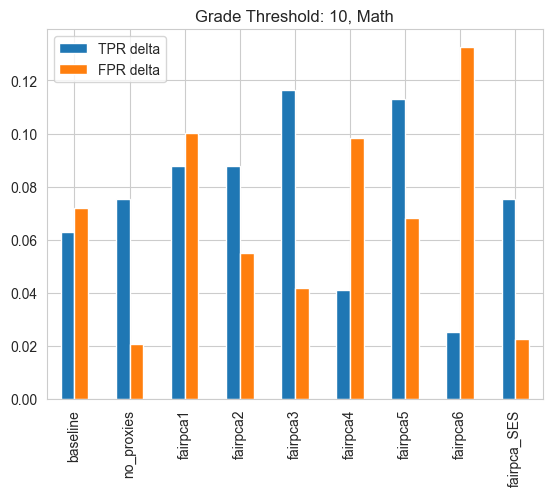

,TPR delta,FPR delta
baseline,0.040698,0.085714
no_proxies,0.290698,0.101544
fairpca1,0.156977,0.036680
fairpca2,0.258721,0.092278
fairpca3,0.165698,0.036680
fairpca4,0.305233,0.074517
fairpca5,0.337209,0.047876
fairpca6,0.328488,0.011197
fairpca_SES,0.156977,0.050965


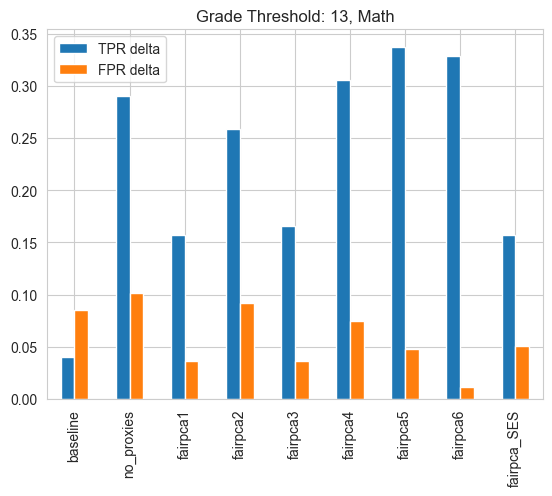

,TPR delta,FPR delta
baseline,0.039596,0.133333
no_proxies,0.008604,0.000000
fairpca1,0.017208,0.081818
fairpca2,0.012906,0.033333
fairpca3,0.000000,0.033333
fairpca4,0.007463,0.181818
fairpca5,0.011765,0.090909
fairpca6,0.023529,0.272727
fairpca_SES,0.011765,0.000000


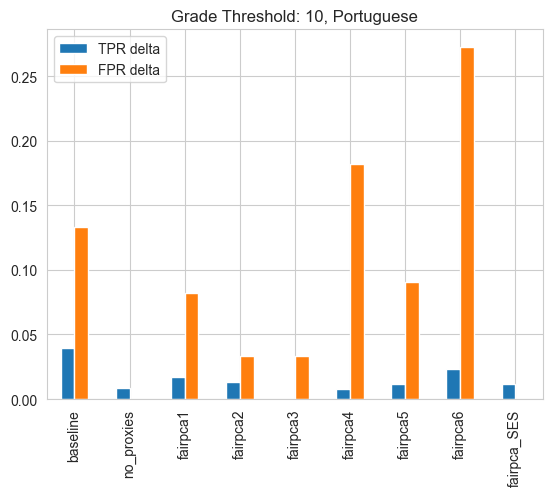

,TPR delta,FPR delta
baseline,0.306743,0.257401
no_proxies,0.041785,0.149671
fairpca1,0.014245,0.074013
fairpca2,0.003799,0.046053
fairpca3,0.027540,0.018914
fairpca4,0.011396,0.017270
fairpca5,0.187085,0.087171
fairpca6,0.055081,0.197368
fairpca_SES,0.047483,0.238487


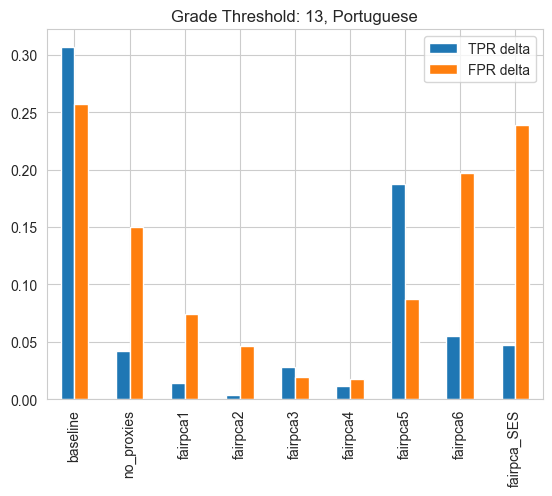

In [190]:
def plot_tpr_fpr_deltas(experiment: pd.DataFrame) -> None:
    grade_threshold = experiment["Grade threshold"].iloc[0]
    course = experiment["Course"].iloc[0]
    exp = experiment[["Type", "TPR delta", "FPR delta"]].set_index("Type")

    # create labels
    idx_labels = []
    for i, x in enumerate(exp.index.to_list()):
        if i == len(tess) - 1:
            idx_labels.append(x + "_SES")
        elif x == "fairpca":
            idx_labels.append(x + str(i - 1))
        else:
            idx_labels.append(x)

    exp.index = idx_labels

    # show table
    display(exp)

    # plot
    exp.plot.bar()
    plt.title(f"Grade Threshold: {grade_threshold}, {course.title()}")
    plt.show()


plot_tpr_fpr_deltas(
    df_results[(df_results["Grade threshold"] == 10) & (df_results["Course"] == "math")]
)

plot_tpr_fpr_deltas(df_results[
        (df_results["Grade threshold"] == 13) & (df_results["Course"] == "math")
    ])

plot_tpr_fpr_deltas( df_results[
        (df_results["Grade threshold"] == 10) & (df_results["Course"] == "portuguese")
    ])

plot_tpr_fpr_deltas(df_results[
        (df_results["Grade threshold"] == 13) & (df_results["Course"] == "portuguese")
    ])